# Problem 2.3: MCMC
This notebook uses the Metropolis-Hastings rule and the approach you developed in part 2.2 to generate posterior samples of the model parameters $b$ given observations $\mathbf{x}=\mathbf{x}_{obs}$.   Most of the code is compeleted for you, but you will have to implement your accept/reject scheme.

## Coding Tasks
There is only one `TODO` in the code below.
1. Implement your accept/reject scheme in the Metropolis-Hastings MCMC algorithm below.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import scatter_matrix

from scipy.integrate import odeint
from scipy.stats import multivariate_normal

# Set the default font size for matplotlib
import matplotlib 
font = {'size'   : 16}
matplotlib.rc('font', **font)

In [2]:
def GetPrior():
    """ Returns the two-dimensional prior mean vector and the 2x2 prior covariance matrix.
    """
    
    mu = np.array([0.5, 20.0, 30.0])
    cov = np.diag([0.01, 100, 100])
    
    return mu, cov


def GetObservations():
    """ Returns the observation times and observed elevations of the baseball. """
 
    obs_times = np.array([0.0, 0.7, 1.4, 2.1, 2.8, 3.5])
    obs_vals = np.array([0.93, 7.43, 19.33, 18.46, 13.10, 5.45])
    
    return obs_times, obs_vals

def PredictPositions(ts, z0, vy0, vz0):
    """
    This function solves for vertical position $z(t)$ of a baseball after it 
    leaves the bat from an initial height $z(t=0)=z0$, intial vertical
    velocity $v_{z0}$ and initial horizontal velocity $v_{y0}$.  It returns
    the vertial positions at the times contained in the vector ts.
    
    ARGS:
        ts (np.array): Observation or prediction times where we want to compute the ball's position.
        z0 (float): Initial height of the above when it leaves the bat
        vy0 (float): Initial horizontal velocity of the ball.
        vz0 (float): Initial vertical velocity of the ball.
        
    RETURNS:
        ys (np.array): A numpy vector containing the horizontal position y(t) of the baseball at each time in ts.
        zs (np.array): A numpy vector containing the vertical position z(t) of the baseball  for each time in ts.
        
    """
    
    m = 0.145
    g = 9.81
    cd = 0.2 # Taken from 
    rho = 1.2 # density of air https://www.baseballaero.com/2019/05/03/baseball-drag-crisis/#:~:text=The%20drag%20coefficient%20is%20twice,circle%20with%20the%20ball's%20diameter.
    A = 0.00418538681 # Cross sectional area for baseball 
    c = 0.5*cd*rho*A
    
    ic = np.array([0.0, z0, vy0, vy0])
    
    def rhs(xv,t):
        x = xv[0:2]
        v = xv[2:4]
        
        drag_force = -c*np.linalg.norm(v)*v
        grav_force = np.array([0,-m*g])
        
        dx_dt = v
        dv_dt = (1.0/m)*(drag_force + grav_force)
        
        return np.concatenate([dx_dt, dv_dt])
    
    if(ts[0]!=0.0):
        ts = np.concatenate([np.zeros(1), ts])
        
    sol = odeint(rhs, ic, ts)
    
    return sol[:,0], sol[:,1]
    
def LogLikelihood(b, obs_var, obs_times, obs_vals):
    """
    This function should evaluate the log of the likelihood function.
    
    ARGS:
        b (np.array): A numpy array of length 3 containing the model initial conditions
        obs_var (float): A scalar containing the variance of the additive noise term epsilon
        obs_times (np.array): A vector of length N containing the observation times
        obs_vals (np.array): A vector of length N containing the vector of observed heights \mathbf{z}=[z(t_1), \ldots, z(t_N)].
        
    RETURNS:
        (float): A scalar containing log( f(z|b) )
        
    """
    
    N = obs_times.shape[0] # The number of observations
    
    z0 = b[0] # The initial vertical position
    vy0 = b[1] # The initial horizontal velocity
    vz0 = b[2] # The initial vertical velocity
    
    # Construct the covariance of \epsilon
    obs_cov = obs_var * np.eye(N)
    
    # Solve the differential equations and predict the ball's position
    #   Note that pred_z is the output of the "g" function in the problem description
    pred_y, pred_z = PredictPositions(obs_times, z0, vy0, vz0)
    

    # TODO: Replace the line below with the likelihood function you derived in part 2.1 
    # hint: The LogPrior function shows how to evaluate a multivariate Gaussian density with the scipy
    log_likelihood = multivariate_normal.logpdf(obs_vals, mean=pred_z, cov=obs_cov)
    
    return log_likelihood

def LogPrior(b, b_mu, b_cov):
    """
    Evaluates the log of the prior density on the initial conditions b.
    
    ARGS:
        b (np.array): A numpy vector with three components containing the initial conditions for the model.
        b_mu (np.array): A numpy vector containing the prior mean.
        b_cov (np.array): A matrix containing the prior covariance matrix.
    
    RETURNS:
        (float): The value of log( f(b) )
    """

    log_prior = multivariate_normal.logpdf(b, mean=b_mu, cov=b_cov)
    return log_prior


### Set up the prior and observations

In [3]:
obs_var = 3.0
obs_times, obs_vals = GetObservations()

In [4]:
prior_mu, prior_cov = GetPrior()

### Plot 1d and 2d marginals of the prior

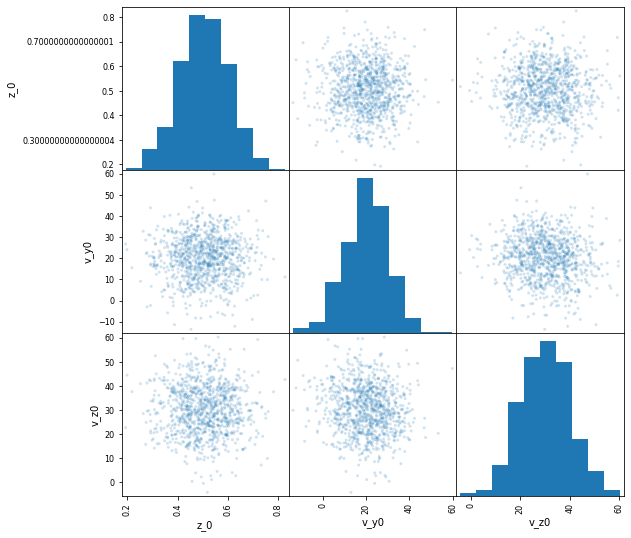

In [5]:
num_samps = 1000
prior_samps = multivariate_normal.rvs(size=(num_samps), mean=prior_mu, cov=prior_cov)

df_prior = pd.DataFrame(prior_samps, columns=['z_0', 'v_y0', 'v_z0'])
scatter_matrix(df_prior, figsize=(9,9), alpha=0.2)
plt.show()

#### Set up for MCMC

In [6]:
# The number of MCMC steps we wish to take
num_steps = 10000

# the number of components in b
b_dim = 3 

# A matrix to hold the posterior samples.  Each row will
# be a sample
bs = np.zeros((num_steps,b_dim))

# A vector holding the log posterior density at each step of the chain
log_posts = np.zeros((num_steps))

# Set the initial point to be the prior mean
bs[0,:] = prior_mu

# Evaluate the log posterior density at the initial point
log_posts[0]  = LogLikelihood(bs[0,:], obs_var, obs_times, obs_vals)
log_posts[0] += LogPrior(bs[0,:], prior_mu, prior_cov)
    
# Construct a zero mean proposal with a scaled version of the prior covariance
prop_scale = 2e-2
proposal = multivariate_normal(np.zeros(b_dim), prop_scale*prior_cov)

#### Metropolis-Hastings MCMC

In [7]:
num_accepts = 0

print('Running MCMC...')
for i in range(num_steps-1):
    
    # The proposed value of b
    prop_b = bs[i,:] + proposal.rvs()
    
    # Evaluate the log of the posterior density (up to a constant) at the proposed point
    prop_post = LogLikelihood(prop_b, obs_var, obs_times, obs_vals)
    prop_post += LogPrior(prop_b, prior_mu, prior_cov)
    
    # Use the Metropolis-Hastings rule to decide if we want to accept or reject this point
    accept_prob = np.exp(prop_post - log_posts[i])
    
    
    #### BEGIN ACCEPT/REJECT STEP ####
    
    # TODO: replace the following line with your accept/reject strategy from part 2.2.
    #       - The should_accept variable should be True if the proposal is accepted and False otherwise
    #       - The acceptance probability is defined above in the accept_prob variable.
    #       - Uniform random numbers can be generated with the np.random.rand() function.
    u = np.random.rand()
    if(u<accept_prob):
        should_accept = True
    else:
        should_accept = False
    
    if(should_accept):
        num_accepts += 1
        bs[i+1,:] = prop_b
        log_posts[i+1] = prop_post
    else:
        bs[i+1,:] = bs[i,:]
        log_posts[i+1] = log_posts[i]
        
    #### END ACCEPT/REJECT STEP ####
    
    if((i>0)&((i % 500) ==0)):
        print('  On step %d/%d, accept rate = %2.1f%%'%(i, num_steps, 100.0*num_accepts/(i+1)))

print('Final Acceptance Rate = %2.1f %%'%(100.0*num_accepts/num_steps))

Running MCMC...
  On step 500/10000, accept rate = 32.3%
  On step 1000/10000, accept rate = 33.9%
  On step 1500/10000, accept rate = 31.6%
  On step 2000/10000, accept rate = 31.7%
  On step 2500/10000, accept rate = 32.6%
  On step 3000/10000, accept rate = 33.1%
  On step 3500/10000, accept rate = 32.7%
  On step 4000/10000, accept rate = 32.2%
  On step 4500/10000, accept rate = 32.5%
  On step 5000/10000, accept rate = 31.7%
  On step 5500/10000, accept rate = 32.0%
  On step 6000/10000, accept rate = 31.9%
  On step 6500/10000, accept rate = 31.8%
  On step 7000/10000, accept rate = 32.0%
  On step 7500/10000, accept rate = 32.0%
  On step 8000/10000, accept rate = 31.8%
  On step 8500/10000, accept rate = 31.9%
  On step 9000/10000, accept rate = 32.1%
  On step 9500/10000, accept rate = 31.9%
Final Acceptance Rate = 31.9 %


### Plot the trace of the MCMC chain

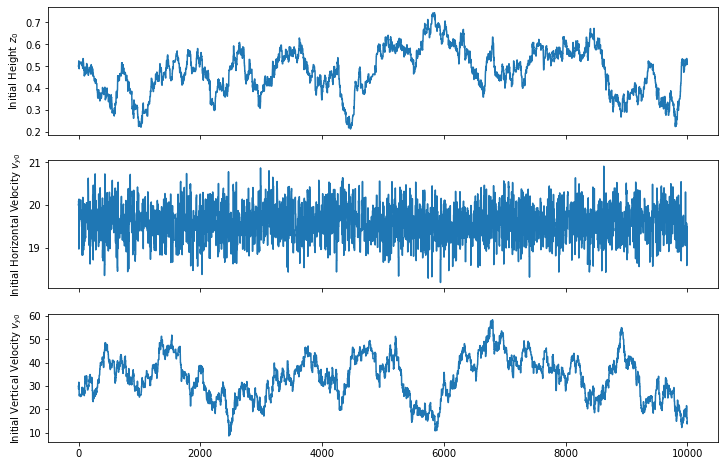

In [8]:
fig, axs = plt.subplots(nrows=3,sharex=True, figsize=(12,8))
axs[0].plot(bs[:,0])
axs[0].set_ylabel('Initial Height $z_0$')

axs[1].plot(bs[:,1])
axs[1].set_ylabel('Initial Horizontal Velocity $v_{y0}$')

axs[2].plot(bs[:,2])
axs[2].set_ylabel('Initial Vertical Velocity $v_{y0}$')

plt.show()

### Plot 1d and 2d marginals of the posterior

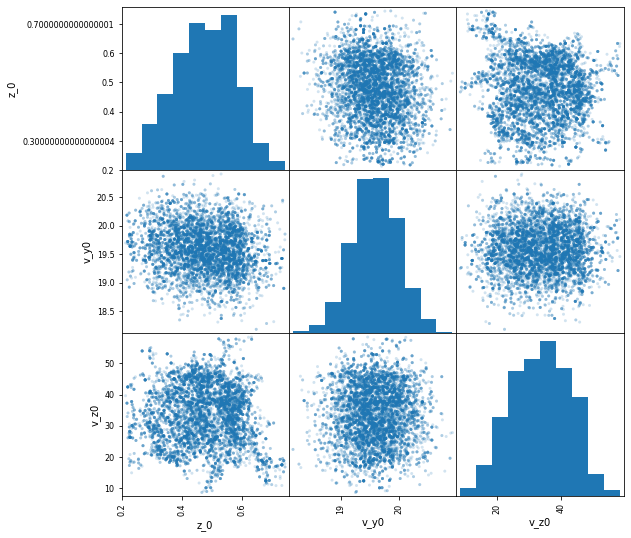

In [9]:
df = pd.DataFrame(bs, columns=['z_0', 'v_y0', 'v_z0'])
scatter_matrix(df, figsize=(9,9), alpha=0.2)
plt.show()

### Plot the posterior predictive distribution

In [10]:
# Define the times where we want to make predictions
pred_times = np.linspace(0,3.75,100)

# Make a prediction with every MCMC sample
heights = np.zeros((num_steps, pred_times.shape[0]))
for i in range(num_steps):
    heights[i,:] = PredictPositions(pred_times, bs[i,0], bs[i,1], bs[i,2])[1]
    

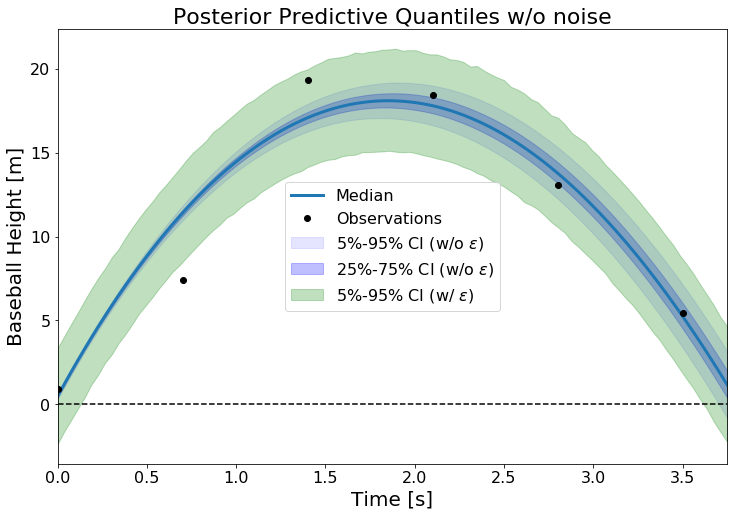

In [24]:
# Compute quantiles of the predictive samples
qs = np.percentile(heights, [5,25,50,75,95], axis=0)

# Plot the quantles
plt.figure(figsize=(12,8))
plt.fill_between(pred_times, qs[0], qs[-1], color='b', alpha=0.1, label='5%-95% CI (w/o $\epsilon$)')
plt.fill_between(pred_times, qs[1], qs[-2], color='b', alpha=0.25, label='25%-75% CI (w/o $\epsilon$)')

noisy_heights = heights + np.sqrt(obs_var)*np.random.randn(*heights.shape)
noisy_qs = np.percentile(noisy_heights, [5,25,50,75,95], axis=0)

plt.fill_between(pred_times, noisy_qs[0], noisy_qs[-1], color='g', alpha=0.25, label='5%-95% CI (w/ $\epsilon$)')

plt.plot(pred_times, qs[2], linewidth=3, label='Median')
plt.plot(pred_times, np.zeros(pred_times.shape[0]), '--k')
plt.plot(obs_times, obs_vals, 'ok', label='Observations')
plt.xlim(pred_times[0], pred_times[-1])
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Baseball Height [m]', fontsize=20)
plt.title('Posterior Predictive Quantiles w/o noise', fontsize=22)
plt.show()
